In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import pandas as pd


import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Datasets

MovieLens dataset: https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset

Наверное, самый часто используемый датасет.


Steam games dataset: https://www.kaggle.com/tamber/steam-video-games

Просто потому что интересно. А еще он относительно маленький, и на нем можно легко отлаживать код.

In [2]:
class RecsysDataset(Dataset):
    def __init__(self, history_len, repeats=10):
        self.history_len = history_len
        self.repeats = repeats
    
    def __getitem__(self, index):
        pu = index % len(self.uid_2_user)
        positives = self.user2relevant[pu]
        negatives = list(self.user2negatives[pu])
        history = random.choices(positives, k = self.history_len + 1)
        history, target = history[:-1], history[-1]
        ni = random.choice(negatives)
        return pu, torch.tensor(history, dtype=torch.long), target, ni
    
    def __len__(self):
        return self.repeats * len(self.uid_2_user)
    
    def get_user_relevant(self, user_id):
        return self.user2relevant[user_id]

In [3]:
class MovielensDataset(RecsysDataset):
    def __init__(self, path, history_len=16, repeats=100, rating_threshold=4.0):
        super().__init__(history_len, repeats)
        df = pd.read_csv(f"{path}/ratings.csv")
        df = df[df["rating"] >= rating_threshold]
        df = df[df["userId"].isin(df["userId"].value_counts()[df["userId"].value_counts() > history_len].index)]

        unique_users = df["userId"].unique()
        self.uid_2_user = dict([(i, user) for i, user in enumerate(unique_users)])
        self.user_2_uid = dict([(user, i) for i, user in enumerate(unique_users)])
        unique_items = df["movieId"].unique()
        self.iid_2_item = dict([(i, item) for i, item in enumerate(unique_items)])
        self.item_2_iid = dict([(item, i) for i, item in enumerate(unique_items)])
        movie_ds = pd.read_csv(f"{path}/movies.csv")
        id2name = list(zip(movie_ds["movieId"], movie_ds["title"]))
        self.iid_2_name = dict([(self.item_2_iid[i], name) for i, name in id2name if i in self.item_2_iid])
        self.positive_users = df["userId"].map(lambda x: self.user_2_uid[x]).to_list()
        self.positive_items = df["movieId"].map(lambda x: self.item_2_iid[x]).to_list()
        
        self.user2negatives = [set(range(len(unique_items))) for _ in unique_users]
        self.item2negatives = [set(range(len(unique_users))) for _ in unique_items]
        self.user2relevant = [[] for _ in unique_users]
        for u, i in zip(self.positive_users, self.positive_items):
            self.user2relevant[u].append(i)
            self.user2negatives[u].discard(i)
            self.item2negatives[i].discard(u)
            
    def item_by_id(self, i):
        return self.iid_2_name[i] if i in self.iid_2_name else self.iid_2_item[i]

In [4]:
class SteamDataset(RecsysDataset):
    def __init__(self, path, history_len=16, repeats=100, is_purchase=False, play_threshold=1.0):
        super().__init__(history_len, repeats)
        df = pd.read_csv(path, header=None)
        if is_purchase:
            df = df[df[2] == "purchase"]
        else:
            df = df[(df[2] == "play") & (df[3] >= play_threshold)]
        df = df[df[0].isin(df[0].value_counts()[df[0].value_counts() > history_len].index)]

        unique_users = df[0].unique()
        self.uid_2_user = dict([(i, user) for i, user in enumerate(unique_users)])
        self.user_2_uid = dict([(user, i) for i, user in enumerate(unique_users)])
        unique_items = df[1].unique()
        self.iid_2_item = dict([(i, item) for i, item in enumerate(unique_items)])
        self.item_2_iid = dict([(item, i) for i, item in enumerate(unique_items)])
        self.positive_users = df[0].map(lambda x: self.user_2_uid[x]).to_list()
        self.positive_items = df[1].map(lambda x: self.item_2_iid[x]).to_list()
        
        self.user2negatives = [set(range(len(unique_items))) for _ in unique_users]
        self.item2negatives = [set(range(len(unique_users))) for _ in unique_items]
        self.user2relevant = [[] for _ in unique_users]
        for u, i in zip(self.positive_users, self.positive_items):
            self.user2relevant[u].append(i)
            self.user2negatives[u].discard(i)
            self.item2negatives[i].discard(u)
            
    def item_by_id(self, i):
        return self.iid_2_item[i]

## Код для анализа результатов

In [5]:
def build_ranking(model, users, histories, items, k):
    items = torch.tensor(items, dtype=torch.long).cuda()
    users = torch.tensor(users, dtype=torch.long).cuda()
    histories = torch.tensor(histories, dtype=torch.long).cuda()
    rankings = []
    with torch.no_grad():
        for u in tqdm(range(len(users))):
            user = users[u:u+1].expand_as(items)
            history = histories[u:u+1].expand(len(items), -1)
            values = model(user, items, history)
            values = values.view(-1)
            ranking = items[torch.argsort(values, descending=True)[:k]]
            rankings.append(ranking)
    return torch.stack(rankings)

def compute_metrics(model, dataset, max_users_ctn=1024, max_items_ctn=2**15, k=10, history_size=16):
    # Build rankings according to model and datset
    if max_users_ctn >= len(dataset.uid_2_user):
        users = list(range(len(dataset.uid_2_user)))
    else:
        users = np.random.choice(len(dataset.uid_2_user), max_users_ctn)
    histories = [random.choices(dataset.get_user_relevant(u), k = history_size) for u in users]
    
    if max_items_ctn >= len(dataset.iid_2_item):
        items = list(range(len(dataset.iid_2_item)))
    else:
        items = np.random.choice(len(dataset.iid_2_item), max_items_ctn)
    
    ranking = build_ranking(model, users, histories, items, k).cpu().numpy()
    
    # Compute metrics
    map_at_k = 0.
    ndcg_at_k = 0.
    for i, u in enumerate(users):
        rank = ranking[i]
        relevant = set(dataset.get_user_relevant(u))
        ap_at_k = 0.
        ctn = 0
        dcg_at_k = 0
        idcg_at_k = 0
        for j in range(k):
            if rank[j] in relevant:
                ctn += 1
                ap_at_k += ctn / (j + 1)
                dcg_at_k += 1 / np.log(j+2)
            if len(relevant) > j:
                idcg_at_k += 1 / np.log(j+2)
        ap_at_k /= min(k, max(len(relevant), 1))
        ndcg_at_k += dcg_at_k / len(users) / idcg_at_k
        map_at_k += ap_at_k / len(users)
    return {f"mAP@{k}": map_at_k, f"NDCG@{k}": ndcg_at_k}

In [6]:
def find_similars(model, item, dataset, k=20):
    with torch.no_grad():
        embs = model.item_embedding.weight
        item_emb = embs[item].unsqueeze(0).expand_as(embs)
        norm = (embs**2).sum(-1)**0.5
        dist_cos = ((embs * item_emb).sum(-1)) / norm
        dist_l2 = ((embs - item_emb)**2).sum(-1)**0.5 # L2 distance
        closest_cos = torch.argsort(dist_cos, descending=False)[1:k+1].cpu().numpy()
        closest_l2 = torch.argsort(dist_l2, descending=False)[1:k+1].cpu().numpy()
        return dataset.item_by_id(item), [dataset.item_by_id(i) for i in closest_cos], [dataset.item_by_id(i) for i in closest_l2]
    
def make_recommendations(model, user, dataset, k=20, history_size=16):
    items = list(range(len(dataset.iid_2_item)))
    history = [random.choices(dataset.get_user_relevant(user), k = history_size)]
    ranking = build_ranking(model, [user], history, items, k).cpu().numpy()
    return [dataset.item_by_id(i) for i in ranking[0]]
    

In [12]:
def summarize_results(losses, metrics, target_item, similars_cos, similars_l2, rec):
    print("LOSS PLOT")
    plt.figure(figsize=(9,6))
    plt.plot(list(range(len(losses))), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.tight_layout()
    plt.show()
    print()
    print("METRICS")
    for k in metrics:
        print(f"{k} :: {metrics[k]}")
    print()
    print()
    print("SIMILARS (COSINE DISTANCE)")
    print(f"TARGET: {target_item}")
    for i, similar in enumerate(similars_cos):
        print(f"{i + 1}. {similar}")
    
    print()
    print("SIMILARS (L2 DISTANCE)")
    print(f"TARGET: {target_item}")
    for i, similar in enumerate(similars_l2):
        print(f"{i + 1}. {similar}")
        
    print()
    print()
    print("RECOMENDATIONS")
    for i, r in enumerate(rec):
        print(f"{i + 1}. {r}")

## Models

In [13]:
class SimpleAttn(nn.Module):
    def __init__(self, user_count, item_count, latent_size=64, hidden_size=64):
        super().__init__()
        self.user_embedding = nn.Embedding(user_count, latent_size)
        self.item_embedding = nn.Embedding(item_count, latent_size)
        self.attn_net = nn.Sequential(
            nn.Linear(2 * latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.dense_net = nn.Sequential(
            nn.Linear(3 * latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, user, item, history):
        h = self.item_embedding(history)
        u = self.user_embedding(user)
        i = self.item_embedding(item)
        query = i.unsqueeze(-2).expand_as(h)
        key_query = torch.cat([h, query], dim=-1)
        attn = F.softmax(self.attn_net(key_query), dim=-2)
        h = (attn.expand_as(h) * h).sum(-2)
        x = self.dense_net(torch.cat([u, i, h], dim=-1))
        return x

    def compute_loss(self, y_pred, y_true):
        return F.binary_cross_entropy(y_pred, y_true)

## Train & results

In [14]:
def train_model(model, dataset, epoch=500, lr=1e-4):
    model.cuda()
    optim = Adam(model.parameters(), lr=lr)
    losses = []
    for _ in tqdm(range(epoch)):
        total_loss = 0.
        total_batches = 0.
        for batch in DataLoader(dataset, batch_size=128, num_workers=12, shuffle=True, pin_memory=True):
            pos_u, history, pos_i, neg_i = batch
            pos_u = pos_u.cuda()
            pos_i = pos_i.cuda()
            neg_i = neg_i.cuda()
            history = history.cuda()
            y_pred = model(pos_u, pos_i, history)
            pos_loss = model.compute_loss(y_pred, torch.ones_like(y_pred).float())
            y_pred = model(pos_u, neg_i, history)
            neg_loss = model.compute_loss(y_pred, torch.zeros_like(y_pred).float())
            loss = (pos_loss + neg_loss) / 2
            optim.zero_grad()
            loss.backward()
            optim.step()
            total_loss += loss.item()
            total_batches += 1
        losses.append(total_loss / total_batches)
    metrics = compute_metrics(model, dataset, k=10)
    return losses, metrics


LOSS PLOT


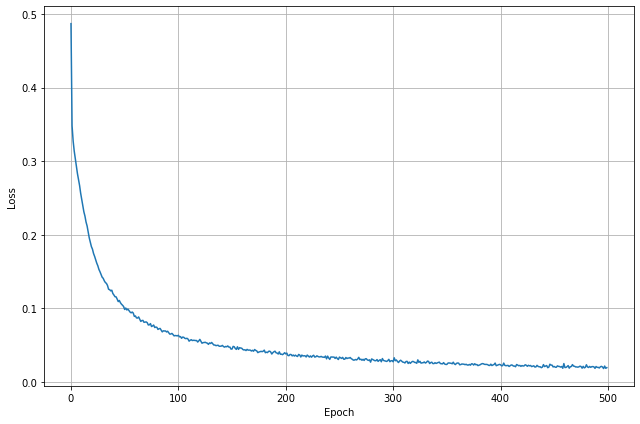


METRICS
mAP@10 :: 0.957195427110846
NDCG@10 :: 0.9744940471437195


SIMILARS (COSINE DISTANCE)
TARGET: S.T.A.L.K.E.R. Shadow of Chernobyl
1. Insurgency
2. Great Permutator
3. Divinity Original Sin Enhanced Edition
4. Lume
5. Red Faction
6. Boo Bunny Plague
7. Deadfall Adventures
8. Ys I
9. Solstice Arena
10. Portal
11. 16bit Trader
12. Borderless Gaming
13. Forge
14. Bloody Good Time
15. Bad Hotel
16. The Guild II Renaissance
17. Avernum 4
18. I am Bread
19. Wargame AirLand Battle
20. Yet Another Zombie Defense

SIMILARS (L2 DISTANCE)
TARGET: S.T.A.L.K.E.R. Shadow of Chernobyl
1. Mount & Blade Warband
2. Shadow Warrior Classic (1997)
3. Battlefield Bad Company 2
4. Audiosurf 2
5. Street Fighter IV
6. Convoy
7. Zafehouse Diaries
8. Cryostasis
9. RAGE
10. Sleeping Dogs
11. Deus Ex Human Revolution - Director's Cut
12. The Amazing Spider-Man 2
13. Spectraball
14. Assault Android Cactus
15. Breath of Death VII 
16. VoidExpanse
17. Making History The Calm & The Storm
18. Loadout
19. Stubbs

In [15]:
dataset = SteamDataset("steam-200k.csv")
model = SimpleAttn(len(dataset.uid_2_user), len(dataset.iid_2_item))
losses, metrics = train_model(model, dataset, epoch=500, lr=1e-3)
item_name, similars_cos, similars_l2 = find_similars(model, 4, dataset, k=20)
rec = make_recommendations(model, 0, dataset)
summarize_results(losses, metrics, item_name, similars_cos, similars_l2, rec)


LOSS PLOT


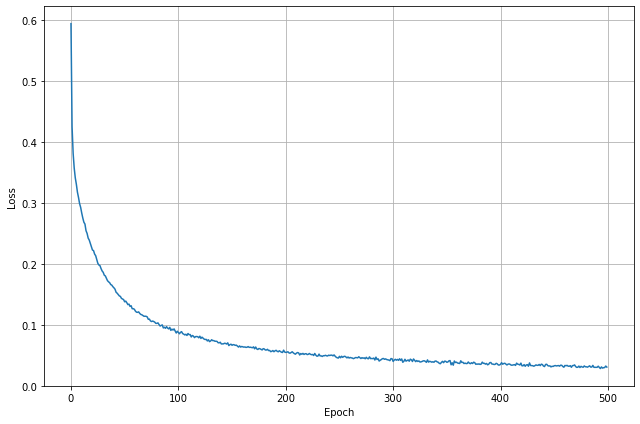


METRICS
mAP@10 :: 0.8984557868390273
NDCG@10 :: 0.9382694232748883


SIMILARS (COSINE DISTANCE)
TARGET: Toy Story (1995)
1. Zoolander (2001)
2. Bulworth (1998)
3. Others, The (2001)
4. Bridge, The (2006)
5. Videodrome (1983)
6. Chappie (2015)
7. Coal Miner's Daughter (1980)
8. Dolls (2002)
9. Wedding Crashers (2005)
10. Family Man, The (2000)
11. Rambo (Rambo 4) (2008)
12. Jurassic World: Fallen Kingdom (2018)
13. Night at the Roxbury, A (1998)
14. Charlie's Angels: Full Throttle (2003)
15. Sicko (2007)
16. Magnificent Ambersons, The (1942)
17. Brüno (Bruno) (2009)
18. Duellists, The (1977)
19. My Best Friend's Girl (2008)
20. Bedtime Stories (2008)

SIMILARS (L2 DISTANCE)
TARGET: Toy Story (1995)
1. Sense and Sensibility (1995)
2. Big Chill, The (1983)
3. Jurassic Park (1993)
4. When Harry Met Sally... (1989)
5. Nutty Professor, The (1996)
6. Armageddon (1998)
7. Minority Report (2002)
8. Fargo (1996)
9. American History X (1998)
10. American Beauty (1999)
11. Inside Out (2015)
12. S

In [16]:
dataset = MovielensDataset("movielens_small")
model = SimpleAttn(len(dataset.uid_2_user), len(dataset.iid_2_item))
losses, metrics = train_model(model, dataset, epoch=500, lr=1e-3)
item_name, similars_cos, similars_l2 = find_similars(model, 0, dataset, k=20)
rec = make_recommendations(model, 0, dataset)
summarize_results(losses, metrics, item_name, similars_cos, similars_l2, rec)

In [ ]:
dataset = SteamDataset("steam-200k.csv")
model = SimpleAttn(len(dataset.uid_2_user), len(dataset.iid_2_item))
losses, metrics = train_model(model, dataset)
item_name, similars_cos, similars_l2 = find_similars(model, 4, dataset, k=20)
rec = make_recommendations(model, 0, dataset)
summarize_results(losses, metrics, item_name, similars_cos, similars_l2, rec)


LOSS PLOT


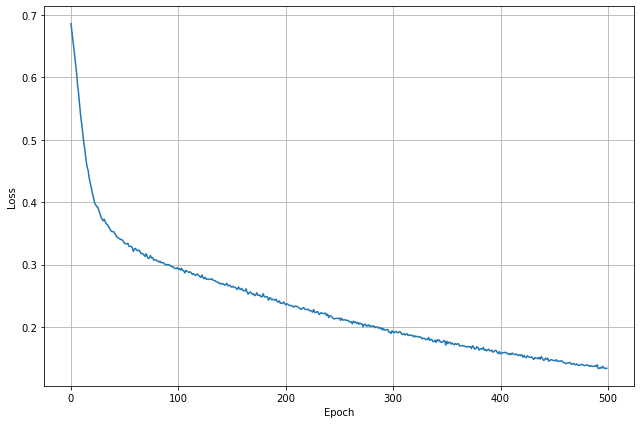


METRICS
mAP@10 :: 0.7909735291322122

SIMILARS
TARGET: Toy Story (1995)
1. Jumanji (1995)
2. Ice Age 2: The Meltdown (2006)
3. Spaceballs (1987)
4. Martin Lawrence Live: Runteldat (2002)
5. Tales from the Crypt Presents: Demon Knight (1995)
6. Joy Luck Club, The (1993)
7. Blood Diamond (2006)
8. Star Wars: Episode V - The Empire Strikes Back (1980)
9. Kill Bill: Vol. 2 (2004)
10. Reservoir Dogs (1992)
11. School of Rock (2003)
12. From Dusk Till Dawn (1996)
13. Easy Money (1983)
14. No Country for Old Men (2007)
15. Munich (2005)
16. Pianist, The (2002)
17. Pretty Woman (1990)
18. Wedding Crashers (2005)
19. Star Trek: Nemesis (2002)
20. Star Wars: Episode IV - A New Hope (1977)


In [12]:
dataset = MovielensDataset("movielens_small")
model = SimpleAttn(len(dataset.uid_2_user), len(dataset.iid_2_item))
losses, metrics = train_model(model, dataset)
item_name, similars_cos, similars_l2 = find_similars(model, 0, dataset, k=20)
rec = make_recommendations(model, 0, dataset)
summarize_results(losses, metrics, item_name, similars_cos, similars_l2, rec)